# **기본 설정**

In [ ]:
# crossentropy(사용자 정의 필요), softmax / dtype = 'float32'
from tensorflow import keras
keras.mixed_precision.set_global_policy('mixed_float16')

"""
class CustomCrossEntropy(tf.keras.losses.Loss):
    def __init__(self, from_logits=False, label_smoothing=0, name='cross_entropy'):
        super().__init__(name=name)
        self.from_logits = from_logits
        self.label_smoothing = label_smoothing

    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        return tf.keras.losses.categorical_crossentropy(
            y_true, y_pred, from_logits=self.from_logits, label_smoothing=self.label_smoothing
        )
-> model.compile(optimizer='adam', loss=CustomCrossEntropy(), metrics=['accuracy'])
"""

In [ ]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

import sys
# 코랩의 경우 나눔 폰트를 설치합니다.
if 'google.colab' in sys.modules:
    !sudo apt-get -qq -y install fonts-nanum
    import matplotlib.font_manager as fm
    font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])
    for fpath in font_files:
        fm.fontManager.addfont(fpath)

# 나눔 폰트를 사용합니다.
import matplotlib

matplotlib.rc('font', family='NanumBarunGothic')
matplotlib.rcParams['axes.unicode_minus'] = False

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 120880 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [ ]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "nlp"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# **Char_RNN**

## **DataSet**

In [ ]:
import tensorflow as tf

shakespeare_url = "https://homl.info/shakespeare"
filepath = tf.keras.utils.get_file("shakespeare.txt", shakespeare_url)
with open(filepath) as f:
    shakespeare_text = f.read()

In [ ]:
#텍스트 인코딩 / 문자 수준 인코딩, 소문자 변환
text_vec_layer = tf.keras.layers.TextVectorization(split = "character",
                                                   standardize = "lower")
text_vec_layer.adapt([shakespeare_text])
encoded = text_vec_layer([shakespeare_text])[0]

#encoded는 2부터 시작하는 정수 인덱스로 문자를 변환한다. (0은 패딩, 1은 사전에 없는 문자)
#그러나 지금 데이터셋에는 0,1이 필요 없으므로 제거
encoded -= 2
n_tokens = text_vec_layer.vocabulary_size()
dataset_size = len(encoded)

In [ ]:
#매우 긴 데이터셋을 RNN에 활용하기 위해 윈도 데이터셋으로 변환
#타깃은 한 스텝 뒤 문자

"""
1. encoded를 입력으로 받고, length 길이의 윈도 데이터셋을 만든다
2. 타깃을 위한 다음 문자가 필요하기 때문에 한 칸 늘린다
3. (윈도를 섞고), 배치로 묶고, 입력/타깃으로 나누고, 프리페치 활성화.
"""
def to_dataset(sequence, length, shuffle = False, seed = None, batch_size = 32):
    ds = tf.data.Dataset.from_tensor_slices(sequence)
    ds = ds.window(length + 1, shift = 1, drop_remainder = True)
    ds = ds.flat_map(lambda window_ds : window_ds.batch(length + 1))
    if shuffle:
        ds = ds.shuffle(buffer_size = 100000, seed = seed)
    ds = ds.batch(batch_size)
    return ds.map(lambda window: (window[:, :-1], window[:, 1:])).prefetch(1)

In [ ]:
#훈련, 검증, 테스트 세트 만들기
tf.random.set_seed(42)

length = 100
train_set = to_dataset(encoded[:1_000_000], length = length, shuffle = True)
valid_set = to_dataset(encoded[1_000_000 : 1_060_000], length = length)
test_set = to_dataset(encoded[1_060_000:], length = length)

## **Model**

In [ ]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=n_tokens, output_dim=16),
    tf.keras.layers.GRU(128, return_sequences=True),
    tf.keras.layers.Dense(n_tokens, activation="softmax", dtype = 'float32')
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model_ckpt = tf.keras.callbacks.ModelCheckpoint(
    "my_shakespeare_model", monitor="val_accuracy", save_best_only=True)
history = model.fit(train_set, validation_data=valid_set, epochs=10,
                    callbacks=[model_ckpt])

#데이터셋은 0,1이 빠져있지만 모델은 텍스트 전처리가 되어있지 않아서 0,1을 뺌
shakespeare_model = tf.keras.Sequential([
    text_vec_layer,
    tf.keras.layers.Lambda(lambda X: X - 2),  # <PAD>나 <UNK> 토큰 없음
    model
])

In [ ]:
#훈련에 한 시간 이상 소요되므로 훈련된 파일 다운로드
url = "https://github.com/ageron/data/raw/main/shakespeare_model.tgz"
path = tf.keras.utils.get_file("shakespeare_model.tgz", url, extract=True)
model_path = Path(path).with_name("shakespeare_model")
shakespeare_model = tf.keras.models.load_model(model_path)

In [ ]:
# 다음 문자열 하나 예측해보기
y_proba = shakespeare_model.predict(["To be or not to b"])[0, -1]
y_pred = tf.argmax(y_proba)  # 가장 가능성이 높은 문자 ID 선택
text_vec_layer.get_vocabulary()[y_pred + 2]

In [ ]:
log_probas = tf.math.log([[0.5, 0.4, 0.1]])  # 확률 = 50%, 40%, 10%
tf.random.set_seed(42)
tf.random.categorical(log_probas, num_samples=8)  # 샘플 8개를 뽑아봄.

def next_char(text, temperature=1):
    y_proba = shakespeare_model.predict([text])[0, -1:]
    rescaled_logits = tf.math.log(y_proba) / temperature
    #같은 글자가 반복해서 나오는걸 방지하기 위한 tf.random.categorical 사용
    char_id = tf.random.categorical(rescaled_logits, num_samples=1)[0, 0]
    return text_vec_layer.get_vocabulary()[char_id + 2]

def extend_text(text, n_chars=50, temperature=1):
    for _ in range(n_chars):
        text += next_char(text, temperature)
    return text

print(extend_text("To be or not to be", temperature=0.01)) #온도가 높을수록 다채로워짐

### **Stateful RNN**

In [ ]:
"""
상태가 있는 RNN (Stateful RNN)
- 상태가 없는 RNN(보통의 RNN)은 매 훈련마다 모델의 은닉 상태를 0으로 초기화한다.
  그러나 한 훈련 배치를 마친 뒤의 상태를 다음 훈련의 초깃값으로 사용하면
  모델이 장기간 패턴을 학습할 수 있다. 이를 '상태가 있는 RNN'이라고 한다.

1. window() 메서드에서 shift를 1 대신 n_steps를 사용해야한다.
2. shuffle() 메서드를 사용하면 안된다.
3. 배치를 구성하기가 어려우므로 간단한 해결책으로 배치를 1로 한다.
"""

# 유틸리티 함수 정의
def to_dataset_for_statful_rnn(sequence, length):
    ds = tf.data.Dataset.from_tensor_slices(sequence)
    ds = ds.window(length + 1, shift = length, drop_remainder = True)
    ds = ds.flat_map(lambda window : window.batch(length + 1)).batch(1)
    return ds.map(lambda window : (window[:, :-1], window[:, 1:])).prefetch(1)

stateful_train_set = to_dataset_for_statful_rnn(encoded[:1_000_000], length)
stateful_valid_set = to_dataset_for_statful_rnn(encoded[1_000_000:1_060_000],
                                                length)
stateful_test_set = to_dataset_for_statful_rnn(encoded[1_060_000:],length)

In [ ]:
"""
\상태가 있는 RNN을 위해 배치 데이터셋을 준비하는 한 가지 방법.

import numpy as np

def to_non_overlapping_windows(sequence, length):
    ds = tf.data.Dataset.from_tensor_slices(sequence)
    ds = ds.window(length + 1, shift=length, drop_remainder=True)
    return ds.flat_map(lambda window: window.batch(length + 1))

def to_batched_dataset_for_stateful_rnn(sequence, length, batch_size=32):
    parts = np.array_split(sequence, batch_size)
    datasets = tuple(to_non_overlapping_windows(part, length) for part in parts)
    ds = tf.data.Dataset.zip(datasets).map(lambda *windows: tf.stack(windows))
    return ds.map(lambda window: (window[:, :-1], window[:, 1:])).prefetch(1)

list(to_batched_dataset_for_stateful_rnn(tf.range(20), length=3, batch_size=2))

->
[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[ 0,  1,  2],
         [10, 11, 12]], dtype=int32)>,
  <tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[ 1,  2,  3],
         [11, 12, 13]], dtype=int32)>),
 (<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[ 3,  4,  5],
         [13, 14, 15]], dtype=int32)>,
"""

In [ ]:
tf.random.set_seed(42)  # 추가 코드 - CPU에서 재현성 보장
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=n_tokens, output_dim=16,
                              batch_input_shape=[1, None]),
    tf.keras.layers.GRU(128, return_sequences=True, stateful=True),
    tf.keras.layers.Dense(n_tokens, activation="softmax", dtype = "float32")
])

# 에포크 끝마다 상태를 재설정하는 사용자 정의 콜백
class ResetStatesCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

model_ckpt = tf.keras.callbacks.ModelCheckpoint(
    "my_stateful_shakespeare_model",
    monitor="val_accuracy",
    save_best_only=True)

model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(stateful_train_set, validation_data=stateful_valid_set,
                    epochs=10, callbacks=[ResetStatesCallback(), model_ckpt])

# 이 모델은 훈련한 배치와 같은 크기의 배치로만 예측을 만들 수 있다.
# 이런 제약을 없애려면 동일한 구조의 상태가 없는 모델을 만들고
# 상태가 없는 모델에 상태가 있는 모델의 가중치를 복사하면 된다.

# **감성 분석**

In [ ]:
#데이터 다운로드
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

raw_train_set, raw_valid_set, raw_test_set = tfds.load(
    name = "imdb_reviews",
    split = ["train[:90%]", "train[90%:]", "test"],
    as_supervised = True
)
tf.random.set_seed(42)
train_set = raw_train_set.shuffle(5000, seed = 42).batch(32).prefetch(1)
valid_set = raw_valid_set.batch(32).prefetch(1)
test_Set = raw_test_set.batch(32).prefetch(1)

In [ ]:
#가장 빈번한 단어 998개(공백으로 구분), 패딩 토큰(0), 모르는 토큰(1)
vocab_size = 1000
text_vec_layer = tf.keras.layers.TextVectorization(max_tokens=vocab_size)
text_vec_layer.adapt(train_set.map(lambda reviews, labels: reviews))

In [ ]:
# mask_zero = True로 모델이 패딩 토큰을 무시하게 함.
# 이게 없으면 짧은 리뷰들이 패딩(0)으로 가득차게 되고
# 처음 문장들을 다 까먹어서 모델이 학습을 못하게 됨.
embed_size = 128
tf.random.set_seed(42)
model = tf.keras.Sequential([
    text_vec_layer,
    tf.keras.layers.Embedding(vocab_size, embed_size, mask_zero=True),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(loss = tf.keras.losses.BinaryCrossentropy(),
              optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=5)

"""
1D합성곱 층과 순환 층을 혼합하여 사용하는 경우처럼 복잡한 모델은
마스킹을 수동으로 구현하여야 한다.

inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)
token_ids = text_vec_layer(inputs)
mask = tf.math.not_equal(token_ids, 0)
Z = tf.keras.layers.Embedding(vocab_size, embed_size)(token_ids)
Z = tf.keras.layers.GRU(128, dropout=0.2)(Z, mask=mask)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(Z)
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
"""

In [ ]:
#ULMFiT (Universal Language Model Fine-tuning)
#사전 훈련된 언어 모델을 가져와 모델을 미세 조정하고 몇 가지 분류기를 추가해 사용하는 것.

import os
import tensorflow_hub as hub

#hub모델은 실행할때마다 다운로드 하므로 이것을 방지하기 위해 환경 변수 지정
os.environ["TFHUB_CACHE_DIR"] = "my_tfhub_cache"
tf.random.set_seed(42)
model = tf.keras.Sequential([
    # trainable=True로 할 경우 코랩에서 메모리 부족 에러가 발생.
    hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                   trainable=False, dtype=tf.string, input_shape=[]),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
"""
class CustomBinaryCrossEntropy(tf.keras.losses.Loss):
    def __init__(self, from_logits=False, label_smoothing=0, name='binary_crossentropy'):
        super().__init__(name=name)
        self.from_logits = from_logits
        self.label_smoothing = label_smoothing

    @tf.function
    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)

        # 수치적 안정성을 위한 로직
        if self.from_logits:
            y_pred = tf.nn.sigmoid(y_pred)

        return tf.reduce_mean(tf.keras.losses.binary_crossentropy(
            y_true, y_pred, label_smoothing=self.label_smoothing
        ))
"""
model.compile(loss = "binary_crossentropy",
              optimizer="nadam",
              metrics=["accuracy"])
model.fit(train_set, validation_data=valid_set, epochs=5)

### **Custom loss 실험**

```
custom / from_logits = False
Epoch 1/5
704/704 [==============================] - 46s 59ms/step - loss: 0.3785 - accuracy: 0.8396 - val_loss: 0.3353 - val_accuracy: 0.8492
Epoch 2/5
704/704 [==============================] - 34s 48ms/step - loss: 0.3255 - accuracy: 0.8605 - val_loss: 0.3289 - val_accuracy: 0.8448
Epoch 3/5
704/704 [==============================] - 33s 47ms/step - loss: 0.3215 - accuracy: 0.8628 - val_loss: 0.3238 - val_accuracy: 0.8532
Epoch 4/5
704/704 [==============================] - 35s 49ms/step - loss: 0.3191 - accuracy: 0.8636 - val_loss: 0.3228 - val_accuracy: 0.8532
Epoch 5/5
704/704 [==============================] - 44s 62ms/step - loss: 0.3154 - accuracy: 0.8660 - val_loss: 0.3196 - val_accuracy: 0.8548

custom / from_logits = True
Epoch 1/5
704/704 [==============================] - 46s 59ms/step - loss: 0.6024 - accuracy: 0.7879 - val_loss: 0.5773 - val_accuracy: 0.8404
Epoch 2/5
704/704 [==============================] - 33s 47ms/step - loss: 0.5739 - accuracy: 0.8499 - val_loss: 0.5736 - val_accuracy: 0.8464
Epoch 3/5
704/704 [==============================] - 34s 48ms/step - loss: 0.5708 - accuracy: 0.8556 - val_loss: 0.5733 - val_accuracy: 0.8364
Epoch 4/5
704/704 [==============================] - 35s 50ms/step - loss: 0.5694 - accuracy: 0.8574 - val_loss: 0.5722 - val_accuracy: 0.8520
Epoch 5/5
```

# **신경망 기계 번역(NMT)**

## **Dataset**

In [ ]:
url = "https://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip"
path = tf.keras.utils.get_file("spa-eng.zip", origin=url, cache_dir="datasets",
                               extract=True)
text = (Path(path).with_name("spa-eng") / "spa.txt").read_text()

2638744/2638744 [==============================] - 0s 0us/step


In [ ]:
import numpy as np

text = text.replace("¡", "").replace("¿", "")
pairs = [line.split("\t") for line in text.splitlines()]
np.random.seed(42)
np.random.shuffle(pairs)
sentences_en, sentences_es = zip(*pairs)  # 쌍을 2개의 리스트로 분리.

In [ ]:
vocab_size = 1000
max_length = 50 #문장 50단어

text_vec_layer_en = tf.keras.layers.TextVectorization(
    vocab_size, output_sequence_length=max_length)
text_vec_layer_es = tf.keras.layers.TextVectorization(
    vocab_size, output_sequence_length=max_length)
text_vec_layer_en.adapt(sentences_en)
#스페인어에는 SOS, EOS 추가
text_vec_layer_es.adapt([f"startofseq {s} endofseq" for s in sentences_es])

In [ ]:
X_train = tf.constant(sentences_en[:100_000]) #총 데이터 12만개
X_valid = tf.constant(sentences_en[100_000:])
X_train_dec = tf.constant([f"startofseq {s}" for s in sentences_es[:100_000]])
X_valid_dec = tf.constant([f"startofseq {s}" for s in sentences_es[100_000:]])
Y_train = text_vec_layer_es([f"{s} endofseq" for s in sentences_es[:100_000]])
Y_valid = text_vec_layer_es([f"{s} endofseq" for s in sentences_es[100_000:]])

## **LSTM Model**

In [ ]:
tf.random.set_seed(42)
encoder_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)
decoder_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)

In [ ]:
embed_size = 128
encoder_input_ids = text_vec_layer_en(encoder_inputs)
decoder_input_ids = text_vec_layer_es(decoder_inputs)
encoder_embedding_layer = tf.keras.layers.Embedding(vocab_size, embed_size,
                                                    mask_zero=True) #마스킹
decoder_embedding_layer = tf.keras.layers.Embedding(vocab_size, embed_size,
                                                    mask_zero=True)
encoder_embeddings = encoder_embedding_layer(encoder_input_ids)
decoder_embeddings = decoder_embedding_layer(decoder_input_ids)
#언어가 많은 단어를 공유하는 경우 임베딩층을 동일하게 사용하면 성능 향상됨.

encoder = tf.keras.layers.LSTM(512, return_state=True)
encoder_outputs, *encoder_state = encoder(encoder_embeddings)

decoder = tf.keras.layers.LSTM(512, return_sequences=True)
#디코더는 encoder에서 얻은 상태 encoder_state를 초기 상태로 사용한다.
decoder_outputs = decoder(decoder_embeddings, initial_state=encoder_state)

output_layer = tf.keras.layers.Dense(vocab_size, activation="softmax")
Y_proba = output_layer(decoder_outputs)

In [ ]:
#입력 2개 출력 1개
model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs],
                       outputs=[Y_proba])

class CustomSparseCategoricalCrossentropy(tf.keras.losses.Loss):
    def __init__(self, from_logits=False, name='sparse_categorical_crossentropy'):
        super().__init__(name=name)
        self.from_logits = from_logits

    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.int64)
        y_pred = tf.cast(y_pred, tf.float32)
        return tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(
            y_true, y_pred, from_logits=self.from_logits
        ))

model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.fit((X_train, X_train_dec), Y_train, epochs=10,
          validation_data=((X_valid, X_valid_dec), Y_valid))

In [ ]:
#훈련은 비슷해도 추론은 model.predict()처럼 수행할 수가 없는데
#그 이유는 디코더가 이전 타임 스텝에서 예측한 단어를 입력으로 기대하기 때문이다.
#간단하게는 아래와 같이 모델을 여러번 호출하고 단어를 하나씩 늘려가며 예측하면 됨.
def translate(sentence_en):
    translation = ""
    for word_idx in range(max_length):
        X = np.array([sentence_en])  # encoder input
        X_dec = np.array(["startofseq " + translation])  # decoder input
        y_proba = model.predict((X, X_dec))[0, word_idx]  # last token's probas
        predicted_word_id = np.argmax(y_proba)
        predicted_word = text_vec_layer_es.get_vocabulary()[predicted_word_id]
        if predicted_word == "endofseq":
            break
        translation += " " + predicted_word
    return translation.strip()

## **양방향 RNN**

In [ ]:
"""
양방향 RNN은 간단하게 Bidirectional로 모델을 감싸면 된다.
그러면 똑같은 모델을 하나 더 복사해서 반대방향으로 진행하게 된다.
시계열 작업은 양방향 RNN이 필요 없지만 텍스트 분류나 텍스트 생성같은 작업에는
양방향 RNN이 필요하다 (the 'right' arm과 the 'right' person을 구별하기 위해서는
arm과 person을 봐야 right의 의미를 구분할 수 있기 때문이다)
"""
tf.random.set_seed(42)
encoder = tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(256, return_state=True))

#그러나 이렇게 하면 디코더 LSTM층의 initial_state에 encoder_state를 전달할 수 없다.
#따라서 아래와 같이 정방향LSTM의 단기,장기 상태와 역방향LSTM의 단기,장기 상태를 연결한다
encoder_outputs, *encoder_state = encoder(encoder_embeddings)
encoder_state = [tf.concat(encoder_state[::2], axis=-1),  # 단기 상태 (0 & 2)
                 tf.concat(encoder_state[1::2], axis=-1)]  # 장기 상태 (1 & 3)

In [ ]:
#똑같이 훈련하면 됨.
decoder = tf.keras.layers.LSTM(512, return_sequences=True)
decoder_outputs = decoder(decoder_embeddings, initial_state=encoder_state)
output_layer = tf.keras.layers.Dense(vocab_size, activation="softmax")

Y_proba = output_layer(decoder_outputs)
model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs],
                       outputs=[Y_proba])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.fit((X_train, X_train_dec), Y_train, epochs=10,
          validation_data=((X_valid, X_valid_dec), Y_valid))

## **Beam Search**

In [ ]:
def beam_search(sentence_en, beam_width, verbose=False):
    X = np.array([sentence_en])  # 인코더 입력
    X_dec = np.array(["startofseq"])  # 디코더 입력
    y_proba = model.predict((X, X_dec))[0, 0]  # 첫 번째 토큰의 확률
    top_k = tf.math.top_k(y_proba, k=beam_width)
    top_translations = [  # 촤상의 (log_proba, translation) 리스트
        (np.log(word_proba), text_vec_layer_es.get_vocabulary()[word_id])
        for word_proba, word_id in zip(top_k.values, top_k.indices)
    ]

    # 추가 코드 - verbose 모드에서 상위 첫 단어를 표시합니다.
    if verbose:
        print("상위 첫 단어:", top_translations)

    for idx in range(1, max_length):
        candidates = []
        for log_proba, translation in top_translations:
            if translation.endswith("endofseq"):
                candidates.append((log_proba, translation))
                continue  # 번역이 완료되었으므로 번역을 이어가지 않습니다.
            X = np.array([sentence_en])  # 인코더 입력
            X_dec = np.array(["startofseq " + translation])  # 디코더 입력
            y_proba = model.predict((X, X_dec))[0, idx]  # 마지막 토큰의 확률
            for word_id, word_proba in enumerate(y_proba):
                word = text_vec_layer_es.get_vocabulary()[word_id]
                candidates.append((log_proba + np.log(word_proba),
                                   f"{translation} {word}"))
        top_translations = sorted(candidates, reverse=True)[:beam_width]

        # 추가 코드 - verbose 모드의 경우 지금까지의 최상의 번역을 출력합니다.
        if verbose:
            print("지금까지 최상의 번역:", top_translations)

        if all([tr.endswith("endofseq") for _, tr in top_translations]):
            return top_translations[0][1].replace("endofseq", "").strip()

In [ ]:
# 추가 코드 - 빔 검색이 어떻게 도움이 되는지 보여줍니다.
beam_search(sentence_en, beam_width=3, verbose=True)

## **Attention**

In [ ]:
encoder = tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(256, return_sequences=True, return_state=True))

encoder_outputs, *encoder_state = encoder(encoder_embeddings)
encoder_state = [tf.concat(encoder_state[::2], axis=-1),  # 단기 (0 & 2)
                 tf.concat(encoder_state[1::2], axis=-1)]  # 장기 (1 & 3)
decoder = tf.keras.layers.LSTM(512, return_sequences=True)
decoder_outputs = decoder(decoder_embeddings, initial_state=encoder_state)

#어텐션 층에 디코더의 상태와 인코더의 출력을 전달해야하는데
#디코더의 상태를 전달하려면 사용자 정의 메모리셀을 만들어야 하므로
#간단하게 디코더의 출력을 전달한다.(return_sequences = True)
attention_layer = tf.keras.layers.Attention()
attention_outputs = attention_layer([decoder_outputs, encoder_outputs])
output_layer = tf.keras.layers.Dense(vocab_size, activation="softmax")
Y_proba = output_layer(attention_outputs)

In [ ]:
model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs],
                       outputs=[Y_proba])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.fit((X_train, X_train_dec), Y_train, epochs=5,
          validation_data=((X_valid, X_valid_dec), Y_valid))

In [ ]:
translate("I like soccer and also going to the beach")

# **Transformer**

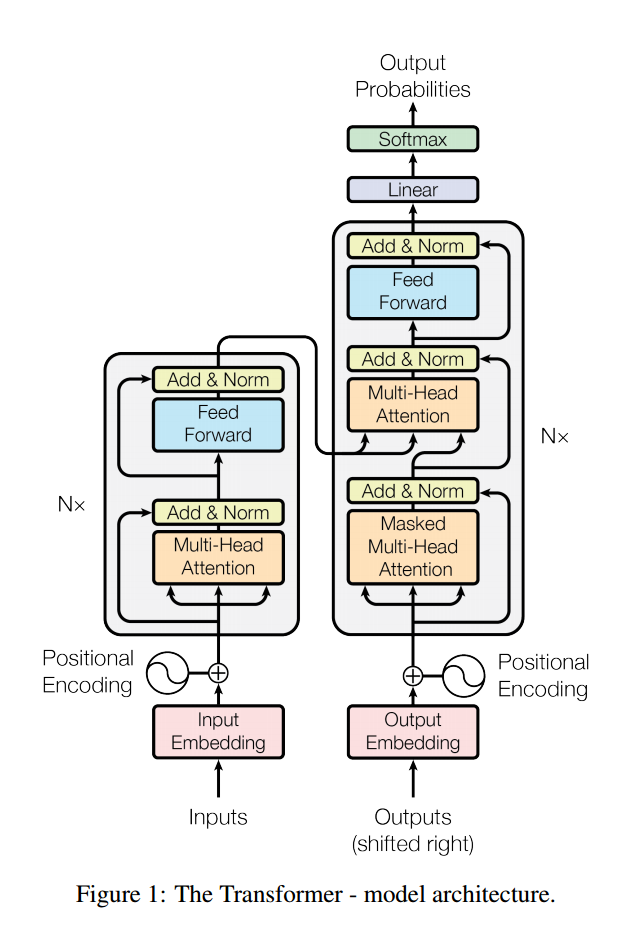![Transformer.png]()

In [ ]:
# 위치 인코딩(positional Encoding)
#단순하게 문장에 오는 단어 순서대로 1,2,3,4...를 임베딩에 더하는 것이다.

max_length = 50  # 전체 훈련 세트에 있는 최대 길이
embed_size = 128
tf.random.set_seed(42)  # 추가 코드 - CPU에서 재현성 보장
pos_embed_layer = tf.keras.layers.Embedding(max_length, embed_size)
batch_max_len_enc = tf.shape(encoder_embeddings)[1]
batch_max_len_dec = tf.shape(decoder_embeddings)[1]
"""
설명
1. __init__ 생성자에서 위치 인코딩 행렬을 미리 계산한다(효율성 때문에)
   max_length: 시퀀스의 최대 길이를 나타냅니다.
   embed_size: 임베딩 벡터의 크기. 짝수여야 한다.

   np.meshgrid를 사용하여 각 임베딩 차원에 대한 위치 인덱스를 생성한다.
   # sin, cos 2개 곡선을 사용해야 같은 y값에 놓인 두 단어를 구분할 수 있다.
   pos_emb[0, :, ::2] = np.sin(...) 짝수 인덱스(::2)는 사인 함수를 사용하고,
   pos_emb[0, :, 1::2] = np.cos(...) 홀수 인덱스(1::2)는 코사인 함수를 사용한다.
   self.pos_encodings 에 계산된 위치 인코딩을 저장한다.
   self.supports_masking = True : 입력 마스크를 다음 층으로 전파.

2. call메서드
   batch_max_length : 입력 배치의 최대 길이를 계산한다.(input은 임베딩레이어의 출력)
   입력에 위치 인코딩을 더하여 반환한다(위 그림 참고)
"""
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, max_length, embed_size, dtype=tf.float32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        assert embed_size % 2 == 0, "embed_size must be even"
        p, i = np.meshgrid(np.arange(max_length),
                           2 * np.arange(embed_size // 2))
        pos_emb = np.empty((1, max_length, embed_size))
        pos_emb[0, :, ::2] = np.sin(p / 10_000 ** (i / embed_size)).T
        pos_emb[0, :, 1::2] = np.cos(p / 10_000 ** (i / embed_size)).T
        self.pos_encodings = tf.constant(pos_emb.astype(self.dtype))
        self.supports_masking = True

    def call(self, inputs):
        batch_max_length = tf.shape(inputs)[1]
        return inputs + self.pos_encodings[:, :batch_max_length]

pos_embed_layer = PositionalEncoding(max_length, embed_size)
#인코더와 디코더는 임베딩 크기가 같은 경우가 많아서 임베딩 층 공유.
encoder_in = pos_embed_layer(encoder_embeddings)
decoder_in = pos_embed_layer(decoder_embeddings)

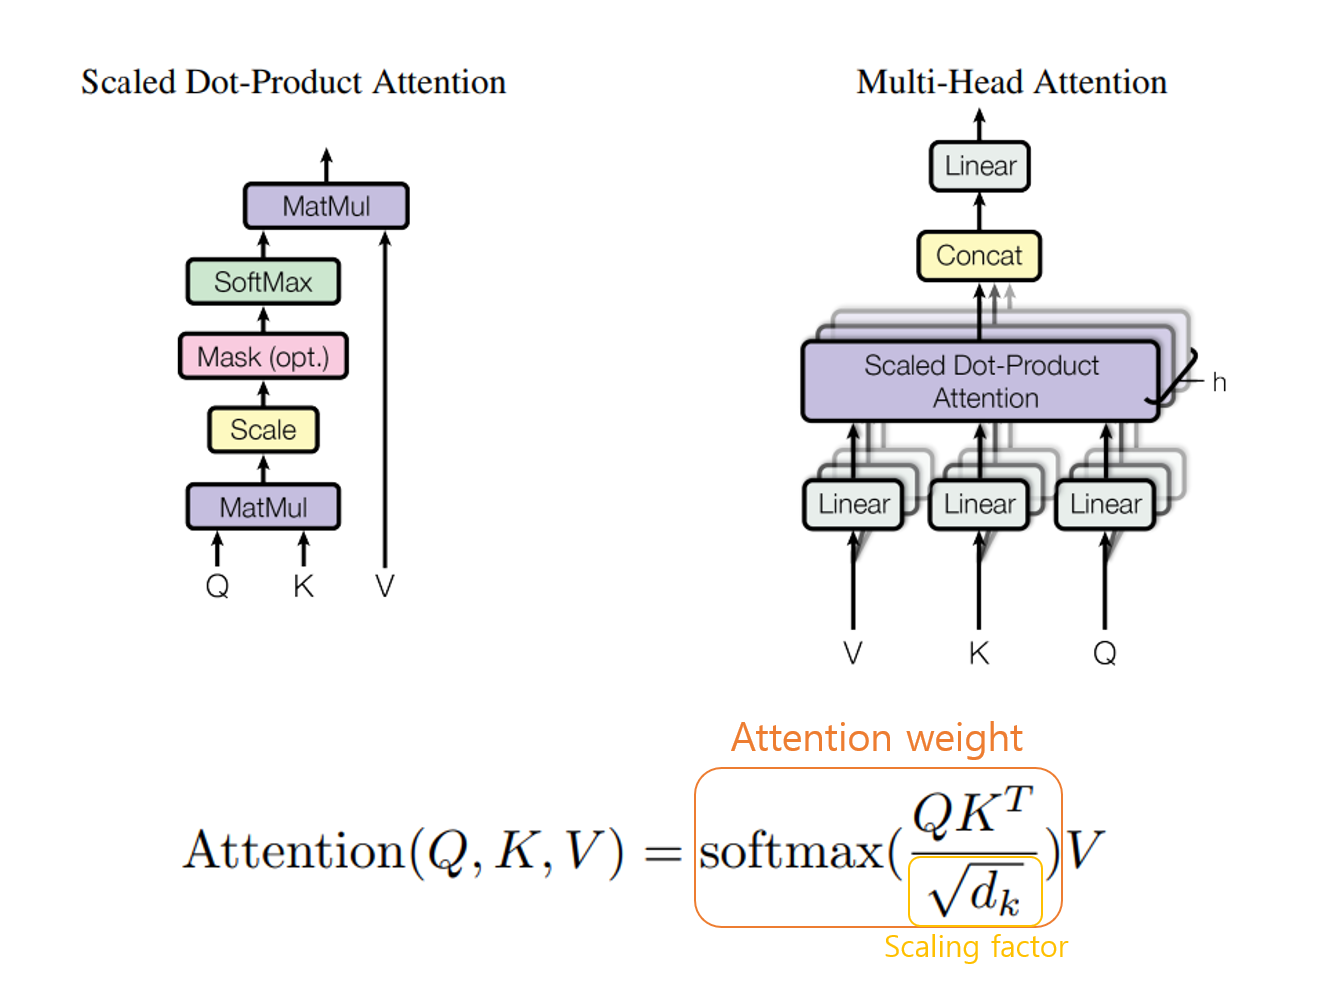

In [ ]:
# 멀티 헤드 어텐션

"""
왜 이런 구조를 사용할까?
단어 표현은 그 안에 텍스트의 위치, 문법과 같은 다양한 정보가 들어가지만
하나의 스케일드 점곱 어텐션 층만 사용하면 한 번에 이런 특징들을 모두 고려할 수 없기 때문에
여러개의 층으로 나누어 단어 표현을 여러 부분 공간으로 다양하게 투영하는 것이다.
어떤 층은 해당 단어가 동사라는 것을 투영하고, 어떤 층은 해당 단어가 현재형이라는 사실만 추출해서
합치면 특정 단어나 구문의 다양한 의미적, 문맥적 특성을 포착할 수 있게 된다.
"""

#인코더 구현
N = 2  # 원본 구조는 6
num_heads = 8
dropout_rate = 0.1
n_units = 128  # 피드 포워드 블록의 첫 번째 Dense 층의 유닛 개수
encoder_pad_mask = tf.math.not_equal(encoder_input_ids, 0)[:, tf.newaxis]

Z = encoder_in
for _ in range(N):
    skip = Z
    attn_layer = tf.keras.layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=embed_size, dropout=dropout_rate)
    Z = attn_layer(Z, value=Z, attention_mask=encoder_pad_mask)
    Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z, skip]))
    skip = Z
    Z = tf.keras.layers.Dense(n_units, activation="relu")(Z)
    Z = tf.keras.layers.Dense(embed_size)(Z)
    Z = tf.keras.layers.Dropout(dropout_rate)(Z)
    Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z, skip]))

In [ ]:
#마스크드 멀티 헤드 어텐션 층을 위한 2개의 마스킹(패딩 마스크, 코잘 마스크)
decoder_pad_mask = tf.math.not_equal(decoder_input_ids, 0)[:, tf.newaxis]
causal_mask = tf.linalg.band_part(  # 하삼각행렬을 생성합니다.
    tf.ones((batch_max_len_dec, batch_max_len_dec), tf.bool), -1, 0)

In [ ]:
#디코더 구현
encoder_outputs = Z  # 인코더의 최종 출력을 저장해 보겠습니다.
Z = decoder_in  # 디코더는 자체 입력으로 시작합니다.
for _ in range(N):
    skip = Z
    attn_layer = tf.keras.layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=embed_size, dropout=dropout_rate)
    Z = attn_layer(Z, value=Z, attention_mask=causal_mask & decoder_pad_mask)
    Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z, skip]))
    skip = Z
    attn_layer = tf.keras.layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=embed_size, dropout=dropout_rate)
    Z = attn_layer(Z, value=encoder_outputs, attention_mask=encoder_pad_mask)
    Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z, skip]))
    skip = Z
    Z = tf.keras.layers.Dense(n_units, activation="relu")(Z)
    Z = tf.keras.layers.Dense(embed_size)(Z)
    Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z, skip]))

In [ ]:
# 훈련
Y_proba = tf.keras.layers.Dense(vocab_size, activation="softmax")(Z)
model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs],
                       outputs=[Y_proba])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.fit((X_train, X_train_dec), Y_train, epochs=5,
          validation_data=((X_valid, X_valid_dec), Y_valid))

Epoch 1/5
3125/3125 [==============================] - 207s 56ms/step - loss: 2.0859 - accuracy: 0.5615 - val_loss: 1.5258 - val_accuracy: 0.6473
Epoch 2/5
3125/3125 [==============================] - 156s 50ms/step - loss: 1.4853 - accuracy: 0.6506 - val_loss: 1.4111 - val_accuracy: 0.6674
Epoch 3/5
3125/3125 [==============================] - 156s 50ms/step - loss: 1.3664 - accuracy: 0.6704 - val_loss: 1.2978 - val_accuracy: 0.6888
Epoch 4/5
3125/3125 [==============================] - 156s 50ms/step - loss: 1.2912 - accuracy: 0.6838 - val_loss: 1.2512 - val_accuracy: 0.6981
Epoch 5/5
3125/3125 [==============================] - 163s 52ms/step - loss: 1.2341 - accuracy: 0.6949 - val_loss: 1.2071 - val_accuracy: 0.7043


In [ ]:
def translate(sentence_en):
    translation = ""
    for word_idx in range(max_length):
        X = np.array([sentence_en])  # encoder input
        X_dec = np.array(["startofseq " + translation])  # decoder input
        y_proba = model.predict((X, X_dec))[0, word_idx]  # last token's probas
        predicted_word_id = np.argmax(y_proba)
        predicted_word = text_vec_layer_es.get_vocabulary()[predicted_word_id]
        if predicted_word == "endofseq":
            break
        translation += " " + predicted_word
    return translation.strip()

translate("I like soccer and also going to the beach")

1/1 [==============================] - 0s 42ms/step


'me gusta y el fútbol también iré a la playa'

## **Hugging Face**

In [ ]:
%pip install -q -U transformers
%pip install -q -U datasets

In [ ]:
from transformers import pipeline
"""
pipeline에는
1.텍스트 생성 pipeline("text-generation")
2.텍스트 분류 pipeline("sentiment-analysis")
3.개체명 인식 ner = pipeline("ner", model="dbmdz/bert-large-cased-finetuned-conll03-english")
4.질문 응답 qa = pipeline("question-answering", model="bert-large-uncased-whole-word-masking-finetuned-squad")
5.텍스트 번역 translator = pipeline("translation", model="Helsinki-NLP/opus-mt-en-de")
6.요약 summarizer = pipeline("summarization", model="t5-small")
7.텍스트 감정 분석 sentiment_analyzer = pipeline("sentiment-analysis")
8.제로샷 분류 zero_shot_classifier = pipeline("zero-shot-classification")

그 외에도 텍스트 완성, 텍스트 유사도 계산, 언어 모델링, 대화형 AI 등등 많음.
"""
classifier = pipeline("sentiment-analysis")
result = classifier("The actors were very convincing.")
print(result) # -> [{'label': 'POSITIVE', 'score': 0.9998071789741516}]

In [ ]:
#편향적인 답변을 할 수도 있다.
classifier(["I am from India.", "I am from Iraq."])

[{'label': 'POSITIVE', 'score': 0.9896161556243896},
 {'label': 'NEGATIVE', 'score': 0.9811071157455444}]

In [ ]:
#입력 문장을 모순/중립/함의 3가지로 나누는 모델
model_name = "huggingface/distilbert-base-uncased-finetuned-mnli"
classifier_mnli = pipeline("text-classification", model=model_name)
classifier_mnli("She loves me. [SEP] She loves me not.")
#[{'label': 'contradiction', 'score': 0.9790191650390625}] -> 97.9%로 모순

In [ ]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModelForSequenceClassification.from_pretrained(model_name)

#문장을 토큰화한 BatchEncoding 객체를 생성한다.
token_ids = tokenizer(["I like soccer. [SEP] We all love soccer!",
                       "Joe lived for a very long time. [SEP] Joe is old."],
                      padding=True, return_tensors="tf")

# 예측 클래스 로짓을 포함하는 TFSequenceClassifierOutput 객체가 생긴다
outputs = model(token_ids)

#이제 로짓을 클래스 확률로 변환하고
Y_probas = tf.keras.activations.softmax(outputs.logits)
#가장 높은 확률을 출력해보면 첫번째 문장은 2, 두번째 문장은 1을 반환한다
Y_pred = tf.argmax(Y_probas, axis=1) #0 = 모순, 1 = 함의, 2 = 중립

All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [ ]:
"""
이 모델을도 일반 케라스 모델처럼 똑같이 훈련할 수 있는데
다만 로짓을 출력하기 때문에 손실에 from_logits = True를 지정하고
훈련 중에 BatchEncoding이(토큰화가) 안되므로 Data 속성을 사용해
일반 딕셔너리로 훈련 파일을 준비해야한다.
"""
sentences = [("Sky is blue", "Sky is red"), ("I love her", "She loves me")]
X_train = tokenizer(sentences, padding=True, return_tensors="tf").data
y_train = tf.constant([0, 2])  # contradiction, neutral
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(loss=loss, optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=2)

Epoch 1/2
1/1 [==============================] - 37s 37s/step - loss: 0.8540 - accuracy: 0.5000
Epoch 2/2
1/1 [==============================] - 0s 42ms/step - loss: 1.1934 - accuracy: 0.5000
